# Action Graph 

### Goals:

- A graph store/database to store and trace any computations during eager execution
- Graph that works with the current in memory worker
- Ability to visualize the graph
- Generate a dependecy list of node, so that any dependeny action can be generated
- Basic query/search functionalities
- Locking/Concurrency

In [1]:
import syft as sy
from syft.service.action.action_graph_service import ActionGraphService, NodeActionDataUpdate, ExecutionStatus
from syft.service.action.action_graph import InMemoryActionGraphStore, InMemoryGraphConfig, InMemoryStoreClientConfig

from syft.service.context import AuthedServiceContext
from syft.node.credentials import SyftSigningKey
from syft.service.action.action_graph import Action
from syft.service.action.numpy import NumpyArrayObject, ActionObject
import numpy as np
import matplotlib.pyplot as plt

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /home/shubham/PySyft


## Scenario for performing some computation

```python

import syft as sy

domain_client = sy.login("....")

dataset = domain_client.datasets[0]

a = dataset.assets["A"]

b = dataset.assets["B"]

c = a + b

d = domain_client.api.numpy.array([1, 2, 3])

e = c * d

# Inplace operation, mutated the value of d
d.astype('int32')

f = d + 48
```

<br>
<br>

**Corresponding Actions Generated**

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d + 48

```

![graph.png](graph.png)

### Initializing the Store

In [2]:
# Create a Config

store_config = InMemoryGraphConfig()

In [3]:
# Initialize the InMemory Store

graph_store = InMemoryActionGraphStore(store_config=store_config)

### Initializing Action Graph Service

In [4]:
action_graph_service = ActionGraphService(store=graph_store)

In [5]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

In [6]:
signing_key = SyftSigningKey.generate()
authed_context = AuthedServiceContext(credentials=signing_key.verify_key)

### Create some dummy data

In [7]:
action_obj_a = ActionObject.from_obj([2, 4, 6])
action_obj_b = ActionObject.from_obj([2, 3, 4])

In [8]:
action_obj_a.id, action_obj_b.id

(<UID: 97da5f8b8347424da57d0cb7d7b63680>,
 <UID: c2f0efd89c194cb3a19c9c4c584adc6c>)

In [9]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_a)

```python
class NodeActionData:
  id: str = 97da5f8b8347424da57d0cb7d7b63680
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-02 01:29:37
  updated_at: str = None
  user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
  is_mutated: str = False

```

In [10]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_b)

```python
class NodeActionData:
  id: str = c2f0efd89c194cb3a19c9c4c584adc6c
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-02 01:29:38
  updated_at: str = None
  user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
  is_mutated: str = False

```

### Action1 -> A + B

In [11]:
action1 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action_obj_a.syft_lineage_id,
    args=[action_obj_b.syft_lineage_id],
    kwargs={}
)
action1

```python
class Action:
  id: str = baf36db0709e49588091cebf2e10a2b7
  path: str = "action.execute"
  op: str = "__add__"
  remote_self: str = 97da5f8b8347424da57d0cb7d7b63680
  args: str = [<LineageID: c2f0efd89c194cb3a19c9c4c584adc6c - 1811602710895870521>]
  kwargs: str = {}
  result_id: str = 63d1b42d84c04eb7a16711aed47e8baa

```

### Save action to Graph

In [12]:
# action_graph_service.add_action

In [13]:
action_graph_service.add_action(context=authed_context, action=action1)

(class NodeActionData:
   id: str = baf36db0709e49588091cebf2e10a2b7
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False,
 class NodeActionData:
   id: str = 63d1b42d84c04eb7a16711aed47e8baa
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False)

### Action2 -> np.array([1, 2, 3])

In [14]:
action_obj_d = ActionObject.from_obj([1, 2, 3])

In [15]:
action_graph_service.add_action_obj(context=authed_context, action_obj=action_obj_d)

```python
class NodeActionData:
  id: str = a6a0e8f6eda748788249e84ed4af3392
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-02 01:29:38
  updated_at: str = None
  user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
  is_mutated: str = False

```

In [16]:
# Create Action2

action2 = Action(
    path="action.execute",
    op="np.array",
    remote_self=None,
    args=[action_obj_d.syft_lineage_id],
    kwargs={}
)
action2

```python
class Action:
  id: str = b1a7e3499164421e99d6153b7b95e054
  path: str = "action.execute"
  op: str = "np.array"
  remote_self: str = None
  args: str = [<LineageID: a6a0e8f6eda748788249e84ed4af3392 - 1680176939419662207>]
  kwargs: str = {}
  result_id: str = 2216e2a296f34b9196a566beb3bc6311

```

In [17]:
# Save action to graph
action_graph_service.add_action(context=authed_context, action=action2)

(class NodeActionData:
   id: str = b1a7e3499164421e99d6153b7b95e054
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False,
 class NodeActionData:
   id: str = 2216e2a296f34b9196a566beb3bc6311
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False)

In [18]:
# 747749f9494345b78e165f13351e52bf: {"data": NodeActionData()}

In [19]:
action1.result_id.id

<UID: 63d1b42d84c04eb7a16711aed47e8baa>

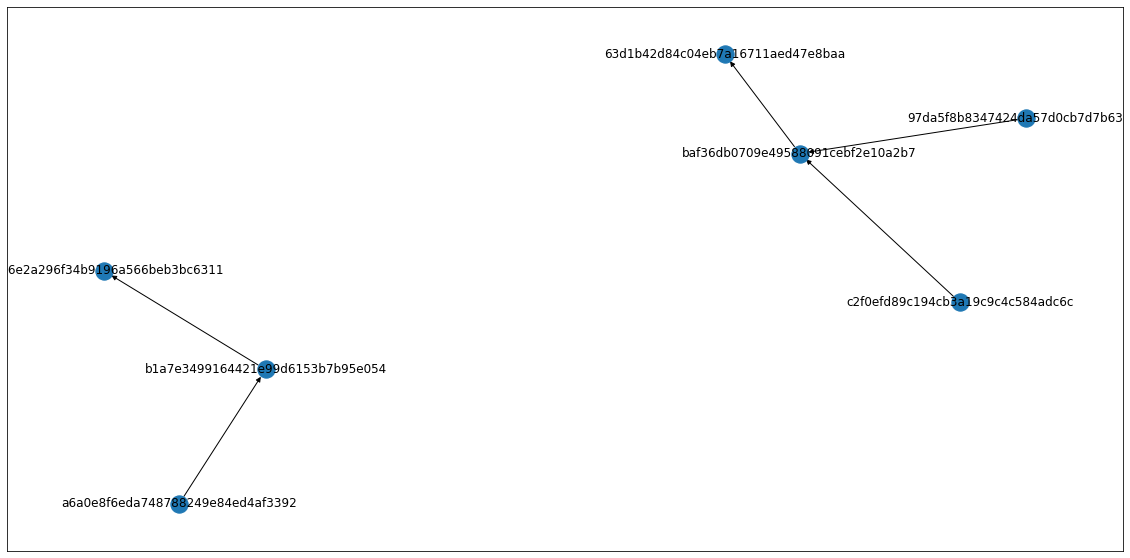

In [20]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action3 -> C * D

In [21]:
action3 = Action(
    path="action.execute",
    op="__mul__",
    remote_self=action1.result_id,
    args=[action2.result_id],
    kwargs={}
)
action3

```python
class Action:
  id: str = 57551faef043491da3547f6224e8f5fc
  path: str = "action.execute"
  op: str = "__mul__"
  remote_self: str = 63d1b42d84c04eb7a16711aed47e8baa
  args: str = [<LineageID: 2216e2a296f34b9196a566beb3bc6311 - 530435004092039078>]
  kwargs: str = {}
  result_id: str = b782dbc315634c72908a90f914ee6bf3

```

In [22]:
action_graph_service.add_action(context=authed_context, action=action3)

(class NodeActionData:
   id: str = 57551faef043491da3547f6224e8f5fc
   type: str = NodeType.ACTION
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False,
 class NodeActionData:
   id: str = b782dbc315634c72908a90f914ee6bf3
   type: str = NodeType.ACTION_OBJECT
   status: str = ExecutionStatus.PROCESSING
   retry: str = 0
   created_at: str = 2023-05-02 01:29:38
   updated_at: str = None
   user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
   is_mutated: str = False)

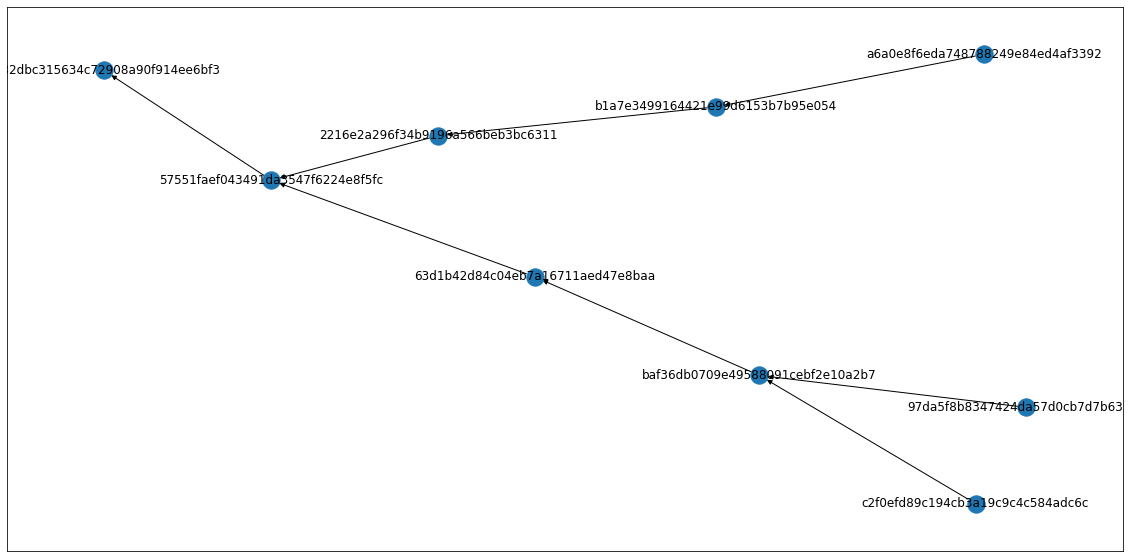

In [23]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action4 -> Mutate type of D

In [24]:
as_type_action_obj = ActionObject.from_obj('np.int32')

In [25]:
action_graph_service.add_action_obj(context=authed_context, action_obj=as_type_action_obj)

```python
class NodeActionData:
  id: str = 1929581539c94d508a705e8edb1441ae
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-02 01:29:42
  updated_at: str = None
  user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
  is_mutated: str = False

```

In [26]:
action4 = Action(
    path="action.execute",
    op="astype",
    remote_self=action2.result_id,
    args=[as_type_action_obj.syft_lineage_id],
    kwargs={},
    result_id=action2.result_id
)
action4

```python
class Action:
  id: str = f0fc71bdc31742f28651c0f2be0e89e3
  path: str = "action.execute"
  op: str = "astype"
  remote_self: str = 2216e2a296f34b9196a566beb3bc6311
  args: str = [<LineageID: 1929581539c94d508a705e8edb1441ae - 1421764435585707064>]
  kwargs: str = {}
  result_id: str = 2216e2a296f34b9196a566beb3bc6311

```

In [27]:
action_graph_service.add_action(context=authed_context, action=action4)

<class 'syft.service.response.SyftError'>: Node already exists in the graph: class NodeActionData:
  id: str = 2216e2a296f34b9196a566beb3bc6311
  type: str = NodeType.ACTION_OBJECT
  status: str = ExecutionStatus.PROCESSING
  retry: str = 0
  created_at: str = 2023-05-02 01:29:43
  updated_at: str = None
  user_verify_key: str = 82c25958d321f3c3a72ffda99ac9d5f281ebaa2c16da609b8d2d20a0a6e83536
  is_mutated: str = False

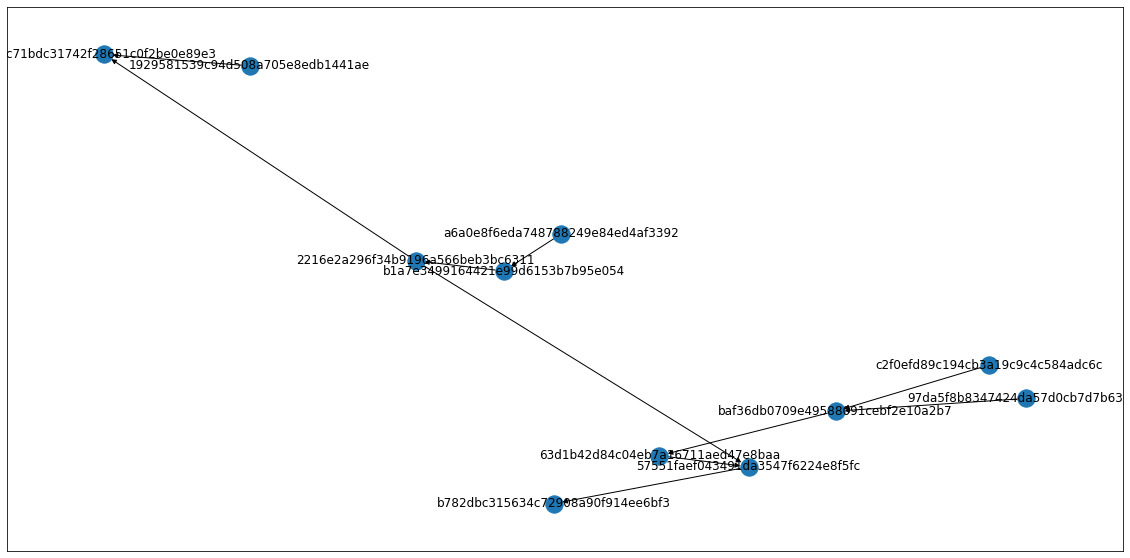

In [28]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

In [ ]:
action_2_node_data = action_graph_service.store.get(uid=action2.id, credentials=authed_context.credentials).ok()
action_2_node_data

In [ ]:
action_graph_service.update(context=authed_context, action_id=action2.id, node_data=NodeActionDataUpdate(is_mutated=True))

In [ ]:
action_graph_service.store.get(uid=action2.id, credentials=authed_context.credentials).ok()

In [ ]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

### Action5 -> D + 48

In [ ]:
arg_action_obj = ActionObject.from_obj(48)

In [ ]:
# action2.result_id == action4.result_id

In [ ]:
action5 = Action(
    path="action.execute",
    op="__add__",
    remote_self=action2.result_id,
    args=[arg_action_obj.syft_lineage_id],
    kwargs={},
)
action5

In [ ]:
action_graph_service.add_action(context=authed_context, action=action5)

In [ ]:
plt.figure(figsize=(20, 10))
action_graph_service.store.graph.visualize()

In [ ]:
action1.id, action2.id, action3.id, action4.id, action5.id

```

action1 -> a + b

action2 -> initialization of variable `d`

action3 -> c * d

action4 -> inplace updation of type of `d` (d.astype('int32'))

action5 -> d + 48

```

## Filtering Actions in the Graph

### Filter by ActionStatus

```
ActionStatus
- PROCESSING
- DONE
- FAILED
```

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.PROCESSING)

In [ ]:
action_graph_service.get_by_action_status(context=authed_context, status=ActionStatus.DONE)

### Filter by Particular User

In [ ]:
action_graph_service.get_by_verify_key(context=authed_context, verify_key=signing_key.verify_key)

In [ ]:
### Serde 

In [ ]:
# bytes_data = sy.serialize(graph_store, to_bytes=True)

In [ ]:
# graph_store = sy.deserialize(bytes_data, from_bytes=True)